# Quick Start

In this section, we are going to generate some synthetic multivariate time series data, inject some anomalies into test data. And then use some Machine learning techniques to detect these anomalies.

In [1]:
%load_ext autoreload
%load_ext lab_black
%load_ext autotime
%autoreload 2

time: 1.51 ms (started: 2023-01-05 12:05:21 -08:00)


In [2]:
import pandas as pd
import random
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["figure.figsize"] = [9, 2]
plt.rcParams["figure.dpi"] = 200
plt.rcParams["agg.path.chunksize"] = 100000
pd.set_option("plotting.backend", "matplotlib")
random.seed(42)

time: 550 ms (started: 2023-01-05 12:05:22 -08:00)


## 1. Data Generation 

Numalogic provides a synthetic time series data generator, that can be used to experiment and evaluate different ML alogorithms. Here we are generaing 3 timeseries (num_series) with 8000 data points (seq_len).

For more details on synthetic data generation, please refer to [data generator](../docs/data-generator.md)

In [3]:
from numalogic.synthetic import SyntheticTSGenerator

ts_generator = SyntheticTSGenerator(
    seq_len=8000,
    num_series=3,
    freq="T",
    primary_period=720,
    secondary_period=6000,
    seasonal_ts_prob=1.0,
    baseline_range=(200.0, 350.0),
    slope_range=(-0.001, 0.01),
    amplitude_range=(10, 75),
    cosine_ratio_range=(0.5, 0.9),
    noise_range=(5, 15),
)

# shape: (8000, 1) with column names [s1]
ts_df = ts_generator.gen_tseries()  

time: 472 ms (started: 2023-01-05 12:05:24 -08:00)


<AxesSubplot: title={'center': 'Time series data'}>

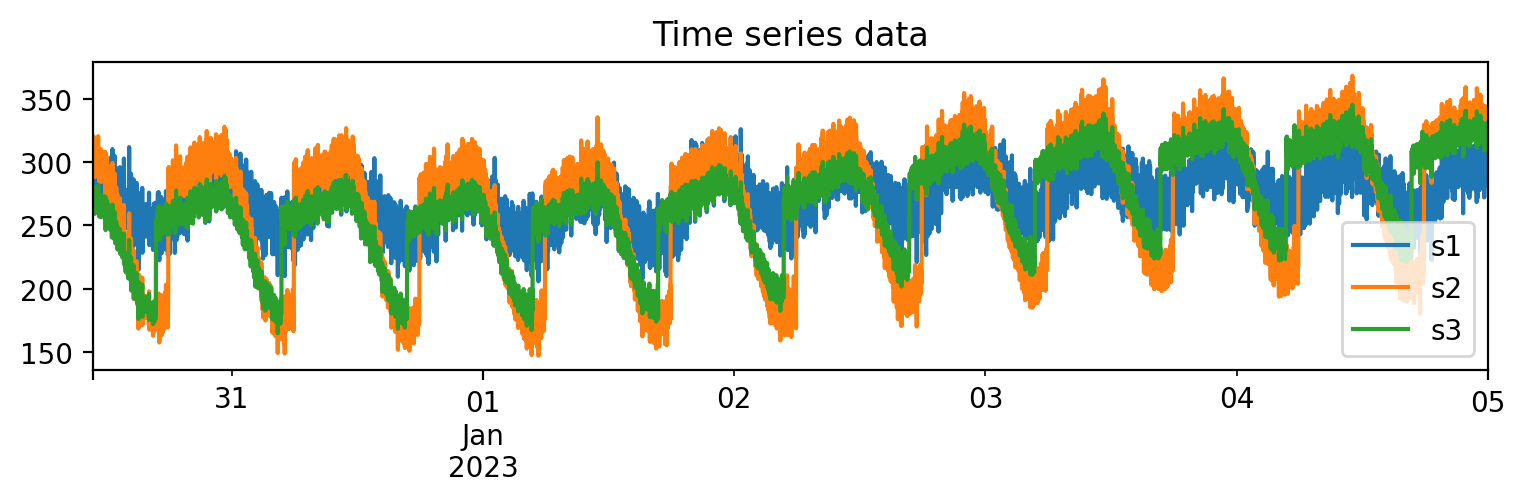

time: 280 ms (started: 2023-01-05 12:05:24 -08:00)


In [4]:
ts_df.plot(title="Time series data")

Now, we split the generated data into train and test dataframes, with test set size 1000 leaving 7000 datapoints for training.

In [5]:
train_df, test_df = ts_generator.train_test_split(ts_df, test_size=1000)

time: 1.23 ms (started: 2023-01-05 12:05:25 -08:00)


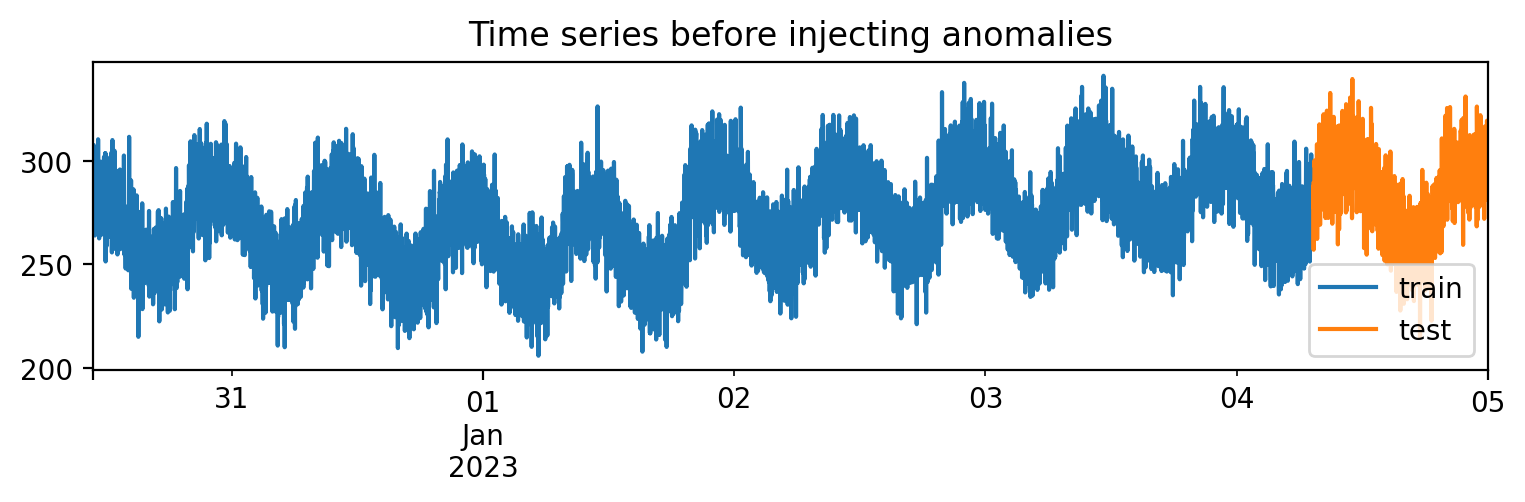

time: 188 ms (started: 2023-01-05 12:05:26 -08:00)


In [6]:
ax = train_df["s1"].plot(label="train")
test_df["s1"].plot(ax=ax, label="test", title="Time series before injecting anomalies")
plt.legend()

## 2. Inject anomalies:

Now, we inject anomalies into the test set using the `AnomalyGenerator`. Here we are adding `contextual` anomalies, you could also try `causal` or `collective` anomalies.

In [7]:
from numalogic.synthetic import AnomalyGenerator

injected_cols = ["s1", "s2"]  # columns to inject anomalies
anomaly_generator = AnomalyGenerator(train_df, anomaly_type="contextual", anomaly_ratio=0.3)
outliers_test_df = anomaly_generator.inject_anomalies(
    test_df, cols=injected_cols, impact=1.5
)

time: 10.5 ms (started: 2023-01-05 12:05:28 -08:00)


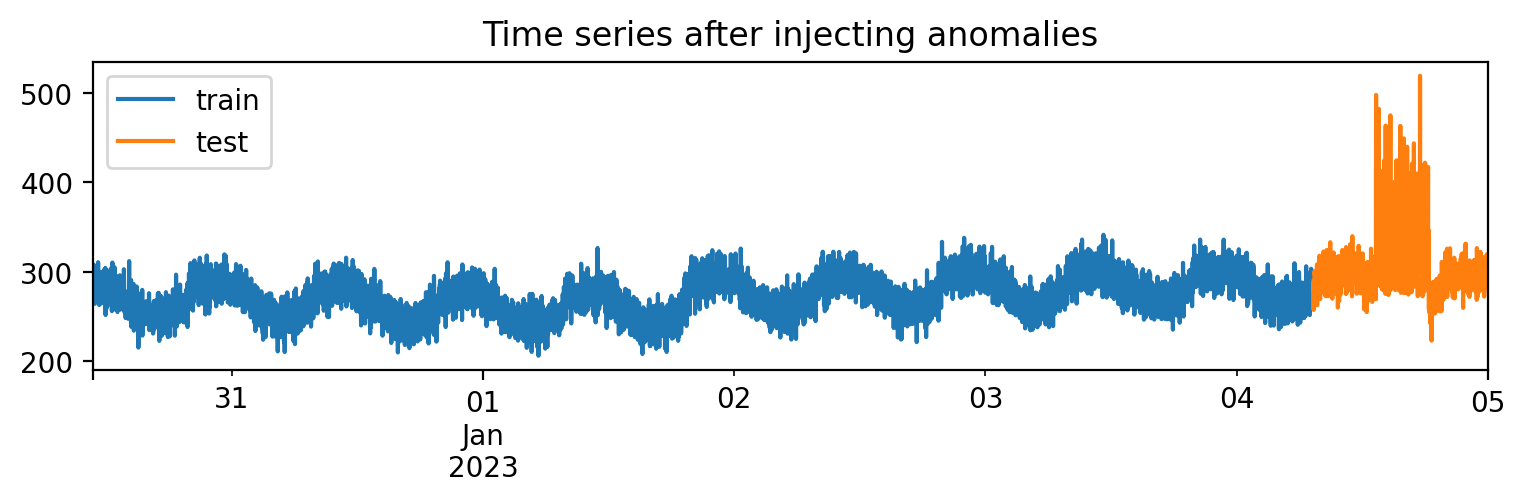

time: 157 ms (started: 2023-01-05 12:05:28 -08:00)


In [8]:
ax = train_df["s1"].plot(label="train")
outliers_test_df["s1"].plot(ax=ax, label="test", title="Time series after injecting anomalies")
plt.legend()

## 3. Pre-Processing:

Pre-processing is an optional step, where we can clean, scale or transform the data. We can transform the features by scaling each feature to a given range, while keeping the shape of the distribution same. 

Here we are using `MinMaxScaler`, you could also try other scalers like `StandarScaler` or `RobustScaler`.

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_df.to_numpy())
X_test = scaler.transform(outliers_test_df.to_numpy())

time: 2.39 ms (started: 2023-01-05 12:05:30 -08:00)


## 4. Training:

In the training step, we define the model and train it on the training data set.

In [10]:
from torch.utils.data import DataLoader
from numalogic.models.autoencoder import AutoencoderTrainer
from numalogic.models.autoencoder.variants import SparseConv1dAE, Conv1dAE, VanillaAE
from numalogic.tools.data import StreamingDataset

seq_len = 36

model = SparseConv1dAE(seq_len=seq_len, in_channels=3, enc_channels=8)
trainer = AutoencoderTrainer(max_epochs=30, enable_progress_bar=True)
trainer.fit(model, train_dataloaders=DataLoader(StreamingDataset(X_train, seq_len=seq_len), batch_size=128))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-01-05 12:05:34,435 - INFO - epoch 0, loss: 1.13
2023-01-05 12:05:40,241 - INFO - epoch 5, loss: 0.119
2023-01-05 12:05:46,225 - INFO - epoch 10, loss: 0.0565
2023-01-05 12:05:51,849 - INFO - epoch 15, loss: 0.0362
2023-01-05 12:05:57,434 - INFO - epoch 20, loss: 0.0276
2023-01-05 12:06:02,940 - INFO - epoch 25, loss: 0.023
`Trainer.fit` stopped: `max_epochs=30` reached.


time: 34.9 s (started: 2023-01-05 12:05:32 -08:00)


## 5. Threshold calculation:

After training the main model, we need to perform a threshold calculation. The autoencoder tries to encode the representation of the normal input data,
and tries to reconstuct the output. The difference between the actual input and the reconstructed output is what we call as the reconstruction error.

Some amount of recconstruction error is normal, and we need to know what amount is normal, and what can be called as an outlier.

In [11]:
# Calculate training set reconstruction error
train_reconerr = trainer.predict(model, dataloaders=DataLoader(StreamingDataset(X_train, seq_len=seq_len)))
train_reconerr.shape

torch.Size([7000, 3])

time: 2.45 s (started: 2023-01-05 12:08:03 -08:00)


Now, we say that anything more than 3 times the standard deviation from the mean is anomalous.

In [12]:
# Calculate the threshold
from numalogic.models.threshold import StdDevThreshold

threshold_clf = StdDevThreshold()
threshold_clf.fit(train_reconerr.numpy())

StdDevThreshold()

time: 3.59 ms (started: 2023-01-05 12:08:07 -08:00)


## 6. Inference:

Now, we use the trained model from above to predict anomalies in the test data. The predict method return the reconstruction error produced by the model. 

Score method returns the anomaly score, calculated using thresholds. If the score is less than 1, it indicates an inlier. And the score greater than 1 indicates an outlier or anomaly.

In [13]:
# Get the reconstruction error on the test set
test_recon_err = trainer.predict(model, dataloaders=DataLoader(StreamingDataset(X_test, seq_len=seq_len)))
test_recon_err.shape

torch.Size([1000, 3])

time: 327 ms (started: 2023-01-05 12:08:14 -08:00)


In [14]:
# Get the anomaly score using the threshold estimator.
test_anomaly_score = threshold_clf.predict(test_recon_err)
print(test_recon_err.shape)

torch.Size([1000, 3])
time: 1.51 ms (started: 2023-01-05 12:08:16 -08:00)


<AxesSubplot: >

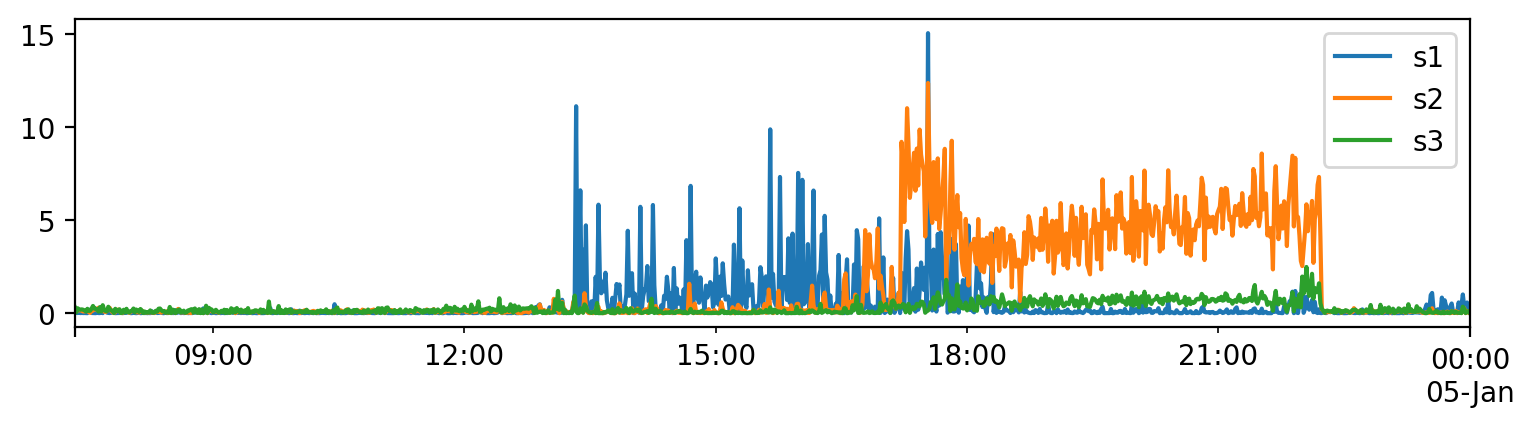

time: 114 ms (started: 2023-01-05 12:08:17 -08:00)


In [15]:
# Convert the score array into a dataframe
anomalies_df = pd.DataFrame(data=test_anomaly_score, columns=outliers_test_df.columns, index=outliers_test_df.index)
anomalies_df.plot()

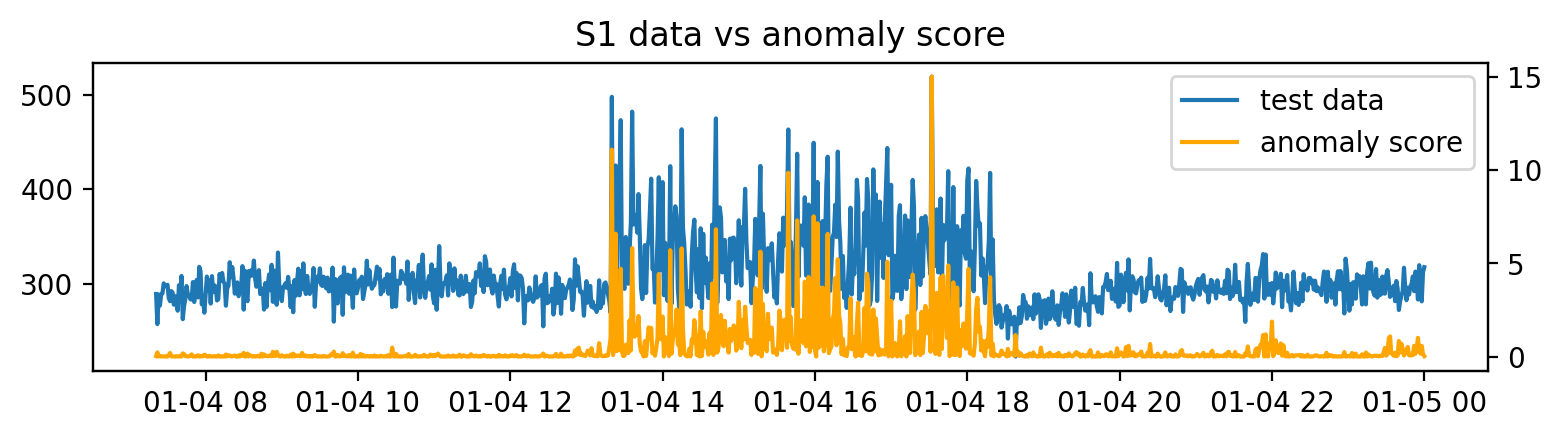

time: 134 ms (started: 2023-01-05 12:08:18 -08:00)


In [16]:
ax1 = plt.subplot()
l1, = ax1.plot(outliers_test_df["s1"])
ax2 = ax1.twinx()
l2, = ax2.plot(anomalies_df["s1"], color="orange")
plt.legend([l1, l2], ["test data", "anomaly score"])
plt.title("S1 data vs anomaly score")
plt.show()

## 7. Post-processing:

Post-processing step is an optional step, where we normalize the anomalies between 0-10. This can make the scores more human interpretable.


In [17]:
from numalogic.postprocess import TanhNorm

postproc_clf = TanhNorm()
test_anomaly_score_norm = postproc_clf.fit_transform(test_anomaly_score)

time: 1.79 ms (started: 2023-01-05 12:08:21 -08:00)


<AxesSubplot: >

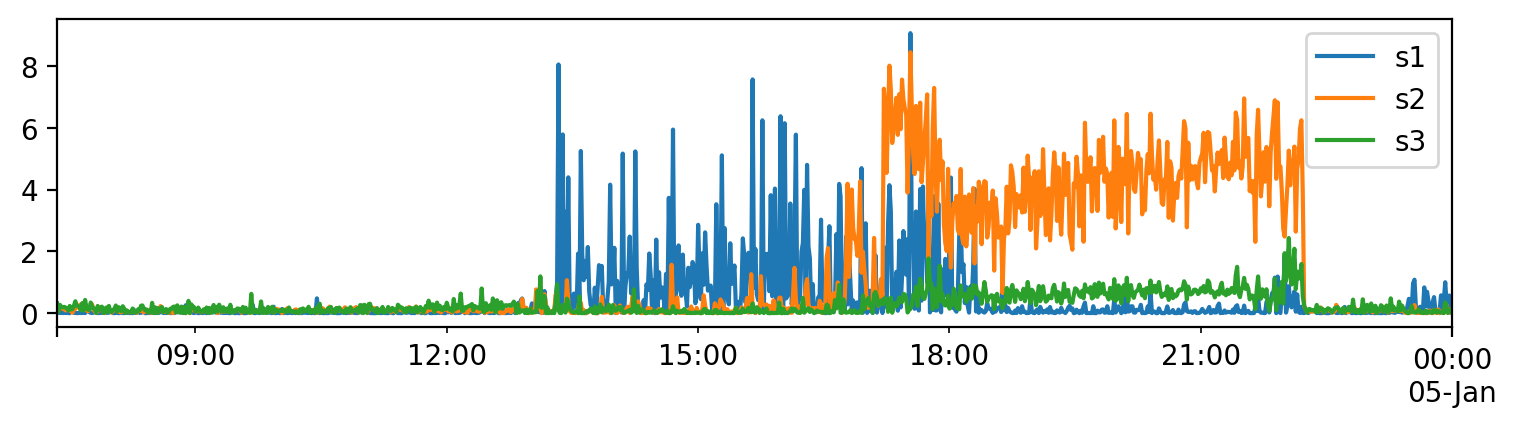

time: 122 ms (started: 2023-01-05 12:08:22 -08:00)


In [18]:
norm_anomalies_df = pd.DataFrame(data=test_anomaly_score_norm, columns=outliers_test_df.columns, index=outliers_test_df.index)
norm_anomalies_df.plot()

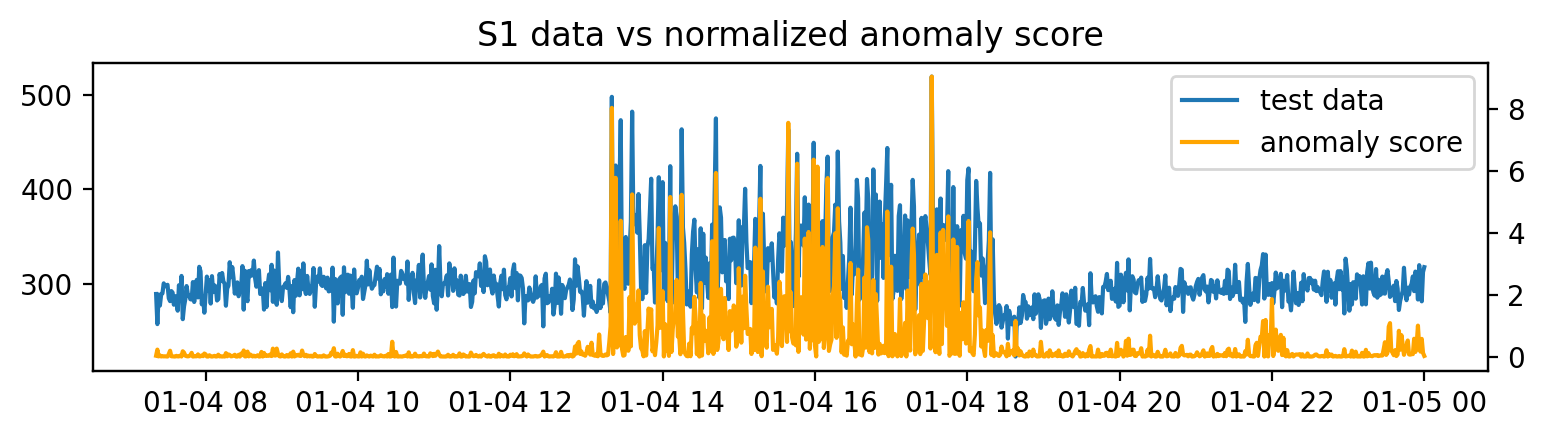

time: 137 ms (started: 2023-01-05 12:08:23 -08:00)


In [19]:
ax1 = plt.subplot()
l1, = ax1.plot(outliers_test_df["s1"])
ax2 = ax1.twinx()
l2, = ax2.plot(norm_anomalies_df["s1"], color="orange")
plt.legend([l1, l2], ["test data", "anomaly score"])
plt.title("S1 data vs normalized anomaly score")
plt.show()